### Import libraries

In [23]:
import os
import pandas as pd

import tensorflow as tf

import spacy
en = spacy.load('/kaggle/input/spacy-models/en_core_web_sm-3.7.1/en_core_web_sm/en_core_web_sm-3.7.1')
sw_spacy = en.Defaults.stop_words

import string
import numpy as np
from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report
#from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
#import nltk
#nltk.download('punkt')
#from nltk.tokenize import word_tokenize
#from nltk.probability import FreqDist

## Read dataset

In [24]:
#df = pd.read_csv("/kaggle/input/dataset-input/daigt_v3.csv")
df = pd.read_csv("/kaggle/input/daigt-v3/daigtv3.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47501 entries, 0 to 47500
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    47501 non-null  object 
 1   label   47501 non-null  float64
dtypes: float64(1), object(1)
memory usage: 742.3+ KB


## Data preprocessing

### Function to remove stop words (it also make the sentences lower)
Just as proof of our operation and to do it also in the test_essays generated by Kaggle.
Our dataset is already pre-processed.



In [25]:
def remove_stop_words_spacy(text):
    if not isinstance(text, str) or not text:
        return ""
    words = [word for word in text.split() if word.lower() not in sw_spacy]
    new_text = " ".join(words)
    return new_text.lower()

## Train test split

In [26]:
y = np.array(df['label'].values)
X_train, X_temp, y_train, y_temp = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [27]:
train_data = pd.DataFrame({'text': X_train, 'label': y_train})
train_dataset = tf.data.Dataset.from_tensor_slices((train_data['text'], train_data['label']))

## Model

### Create TextVectorization layer

#### OUTPUT_SEQUENCE_LENGTH CHOICE

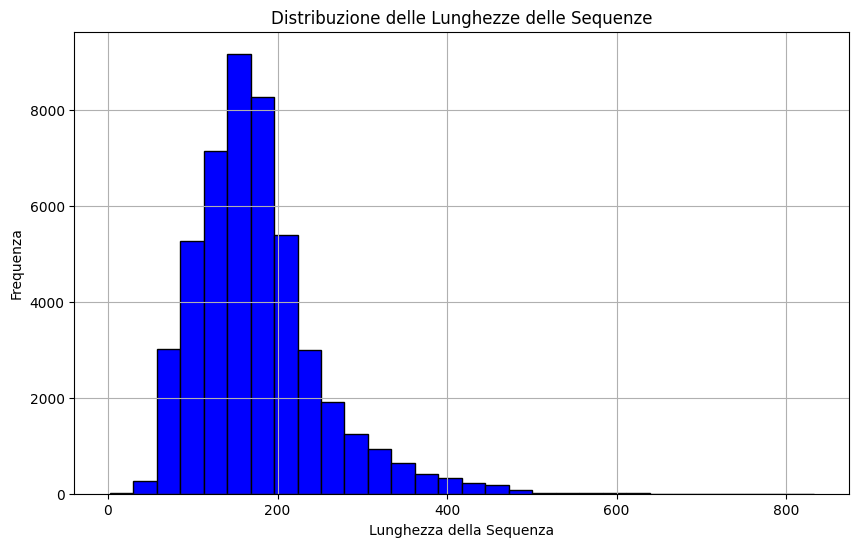

In [28]:
df['sequence_length'] = df['text'].apply(lambda x: len(x.split()))

# Crea un istogramma delle lunghezze delle sequenze
plt.figure(figsize=(10, 6))
plt.hist(df['sequence_length'], bins=30, color='blue', edgecolor='black')
plt.title('Distribuzione delle Lunghezze delle Sequenze')
plt.xlabel('Lunghezza della Sequenza')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

df = df.drop('sequence_length',axis=1)

# proviamo sia con 500 che con 800 come max-lengt

#### MAX_TOKENS CHOICE

In [29]:
#def count_words(text):
#    # Tokenizza il testo in parole
#    words = word_tokenize(text)
#    # Rimuovi le stopwords e trasforma in minuscolo
#    words = [word.lower() for word in words if word.isalpha()]
#    # Restituisci il numero di parole distinte
#    return words

#all_list = []
#for index,row in df.iterrows():
#  a = count_words(row['text'])
#  all_list.extend(a)
    
#print(f"Tutte le parole nel dataset: {len(all_list)}")
#freq_dist = FreqDist(all_list)
#print(f"Parole distinte: {len(freq_dist.most_common())}")


In [30]:
#freq_dist_custom=[]
#FREQUENCY_THRESHOLD = 40
#for item in freq_dist.most_common():
#    if item[1] >= FREQUENCY_THRESHOLD:
#        freq_dist_custom.append(item)
#print(len(freq_dist_custom))

In [31]:
VOCAB_SIZE = 8000
encoder = tf.keras.layers.TextVectorization(
    output_sequence_length=500, # diverso da cristian
    standardize=None,
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

### Create model

In [32]:
from keras import regularizers
model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=3000,
            mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
            units=16,
            return_sequences=True)),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
            units=16)),
        tf.keras.layers.Dense(
            units=8,
            activation = 'relu',
            kernel_regularizer = regularizers.l1(0.1)),
        #tf.keras.layers.Dropout(rate=0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

In [33]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Training

In [34]:
history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/3
1188/1188 [==============================] - 182s 136ms/step - loss: 0.8538 - accuracy: 0.9748 - val_loss: 0.2554 - val_accuracy: 0.9834
Epoch 2/3
1188/1188 [==============================] - 108s 91ms/step - loss: 0.2072 - accuracy: 0.9910 - val_loss: 0.1918 - val_accuracy: 0.9874
Epoch 3/3
1188/1188 [==============================] - 106s 89ms/step - loss: 0.1589 - accuracy: 0.9936 - val_loss: 0.1477 - val_accuracy: 0.9901


In [35]:
#!pip install pip install pydot graphviz

In [45]:
#from tensorflow.keras.utils import plot_model
#model.summary()
#plot_model(model, to_file='/kaggle/working/model_plot.png', show_shapes=True, show_layer_names=True)

TypeError: plot_model() got an unexpected keyword argument 'layer_color'

## Evaluation

In [37]:
#from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve

In [38]:
#y_pred = model.predict(X_test)
#y_pred = (y_pred > 0.5).astype(int)
#y_test = y_test.astype(int)

# Stampa il classification report e l'accuracy score
#report = classification_report(y_test, y_pred)
#accuracy = accuracy_score(y_test, y_pred)
#print(report)
#print("****")
#print(accuracy)

In [39]:
#import seaborn as sns
#conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizzare la matrice di confusione
#plt.figure(figsize=(8, 6))
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
#plt.xlabel('Predicted Label')
#plt.ylabel('True Label')
#plt.title('Confusion Matrix')
#plt.show()


In [40]:
# AUROC calculation
#def plot_roc_curve(y_true, y_scores):
#    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
#    auc_score = roc_auc_score(y_true, y_scores)#

#    plt.figure(figsize=(8, 8))
#    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
#    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
#    plt.xlabel('False Positive Rate')
#    plt.ylabel('True Positive Rate')
#    plt.title('Receiver Operating Characteristic (ROC) Curve')
#    plt.legend()
#    plt.show()

# Get true labels and predicted probabilities for test set
#y_true = test_df['generated'].values
#y_scores = model.predict(test_dataset).reshape(-1)

# Plot ROC curve
#plot_roc_curve(y_test, y_pred)

## Submission

In [41]:
test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
test['text']=test['text'].apply(remove_stop_words_spacy)
#test.info()
test_text = test['text'].values

In [42]:
predictions = model.predict(test_text)
test['generated'] = predictions

1/1 [==============================] - 5s 5s/step


In [43]:
test[['id', 'generated']].set_index('id').to_csv("submission.csv")